In [1]:
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [2]:
import cv2
import os
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

import numpy as np

from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import (BinaryAccuracy, Precision, Recall, AUC, 
                                      FalsePositives, FalseNegatives, TruePositives, TrueNegatives)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu

In [6]:
# folder_var = 'data1/train/malignant/'
# folder_yok = 'data1/train/benign/'
# folder_test_var = 'data1/test/malignant/'
# folder_test_yok = 'data1/test/benign/'

folder_train_pos = 'resized/data1/train/1/'    # positive
folder_train_neg = 'resized/data1/train/0/'     # negative
folder_validation_pos = 'resized/data1/validation/1/'    # positive
folder_validation_neg = 'resized/data1/validation/0/'     # negative
folder_test_pos = 'resized/data2/test/1/'    # positive
folder_test_neg = 'resized/data2/test/0/'     # negative

In [7]:
img_height = img_width = 28
# img_height = img_width = 224  # for hub
def load_images_from_folder(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            i = 0
            if file.endswith('.DS_Store'):
                path = os.path.join(root, file)
                print ("Deleting: %s" % (path))
                if os.remove(path):
                    print ("Unable to delete!")
                else:
                    print ("Deleted...")
                    i += 1
                print("Files Deleted: %d" % (i))

    images = np.array([])
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (img_height, img_width))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # to read images grayscale
#         img = np.reshape(img, (img_height, img_width, 1))
        if img is not None:
            images = np.append(images, img)
    images = np.reshape(images, (len(os.listdir(folder)), img.shape[0], img.shape[1], img.shape[2]))
    return images

In [8]:
x_train_pos = load_images_from_folder(folder_train_pos)
x_train_pos = x_train_pos.astype('float32') / 255.0
y_train_pos = np.ones(len(x_train_pos))

x_train_neg = load_images_from_folder(folder_train_neg)
x_train_neg = x_train_neg.astype('float32') / 255.0
y_train_neg = np.zeros(len(x_train_neg))

x_train = np.concatenate((x_train_pos, x_train_neg), axis=0)
y_train = np.concatenate((y_train_pos, y_train_neg), axis=0)
print(x_train.shape)
print(y_train.shape)

(1300, 28, 28, 3)
(1300,)


In [9]:
x_validation_pos = load_images_from_folder(folder_validation_pos)
x_validation_pos = x_validation_pos.astype('float32') / 255.0
y_validation_pos = np.ones(len(x_validation_pos))

x_validation_neg = load_images_from_folder(folder_validation_neg)
x_validation_neg = x_validation_neg.astype('float32') / 255.0
y_validation_neg = np.zeros(len(x_validation_neg))

x_validation = np.concatenate((x_validation_pos, x_validation_neg), axis=0)
y_validation = np.concatenate((y_validation_pos, y_validation_neg), axis=0)
print(x_validation.shape)
print(y_validation.shape)

(245, 28, 28, 3)
(245,)


In [10]:
x_test_pos = load_images_from_folder(folder_test_pos)
x_test_pos = x_test_pos.astype('float32') / 255.0
y_test_pos = np.ones(len(x_test_pos))

x_test_neg = load_images_from_folder(folder_test_neg)
x_test_neg = x_test_neg.astype('float32') / 255.0
y_test_neg = np.zeros(len(x_test_neg))

x_test = np.concatenate((x_test_pos, x_test_neg), axis=0)
y_test = np.concatenate((y_test_pos, y_test_neg), axis=0)
print(x_test.shape)
print(y_test.shape)

(20, 28, 28, 3)
(20,)


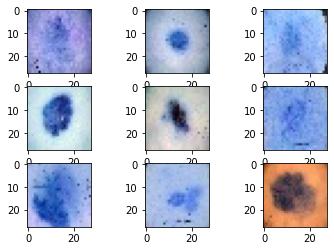

In [11]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(array_to_img(x_train[i]))
plt.show()

In [12]:
inputs = Input(shape=(img_height, img_width, 3))
x = Conv2D(32, 3)(inputs)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)
# print(model.summary())

In [39]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(28, 28, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [40]:
# import tensorflow_hub as hub

# model = Sequential([
#     hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
#                    trainable=False),  # Can be True, see below.
#     Dense(1, activation='softmax')
# ])
# model.build([None, 224, 224, 3])  # Batch input shape

In [41]:
# model.compile(
#     loss=BinaryCrossentropy(from_logits=True),
#     optimizer=Adam(lr=3e-4),
#     metrics=['accuracy'],)

In [42]:
METRICS = [
  TruePositives(name='tp'),
  TrueNegatives(name='tn'),
  FalsePositives(name='fp'),
  FalseNegatives(name='fn'), 
  Precision(name='precision'),
  Recall(name='recall'),
  BinaryAccuracy(name='acc'),
  AUC(name='auc'),
]

model.compile(
    optimizer=Adam(),
    loss=[BinaryCrossentropy(from_logits=True),],
    metrics=METRICS,
)

In [43]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
41/41 [==============================] - 2s 28ms/step - loss: 0.7604 - tp: 24.8333 - tn: 456.3571 - fp: 69.4762 - fn: 136.0000 - precision: 0.2728 - recall: 0.1756 - acc: 0.6919 - auc: 0.5103 - val_loss: 0.6413 - val_tp: 0.0000e+00 - val_tn: 14.0000 - val_fp: 0.0000e+00 - val_fn: 6.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.7000 - val_auc: 0.5595
Epoch 2/30
41/41 [==============================] - 1s 13ms/step - loss: 0.6356 - tp: 14.9048 - tn: 480.0476 - fp: 49.7619 - fn: 141.9524 - precision: 0.2006 - recall: 0.0814 - acc: 0.7213 - auc: 0.5433 - val_loss: 0.6118 - val_tp: 0.0000e+00 - val_tn: 14.0000 - val_fp: 0.0000e+00 - val_fn: 6.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.7000 - val_auc: 0.4821
Epoch 3/30
41/41 [==============================] - 0s 11ms/step - loss: 0.5806 - tp: 21.5476 - tn: 483.5952 - fp: 43.2619 - fn: 138.2619 - precision: 0.3931 - recall: 0.1580 - acc: 0.7491 - auc: 0.6173 - val_loss: 0.6165 - 

41/41 [==============================] - 1s 19ms/step - loss: 0.6229 - tp: 19.5000 - tn: 477.8810 - fp: 49.0952 - fn: 140.1905 - precision: 0.2593 - recall: 0.1169 - acc: 0.7214 - auc: 0.5768 - val_loss: 0.5030 - val_tp: 1.0000 - val_tn: 14.0000 - val_fp: 0.0000e+00 - val_fn: 5.0000 - val_precision: 1.0000 - val_recall: 0.1667 - val_acc: 0.7500 - val_auc: 0.9167
Epoch 23/30
41/41 [==============================] - 1s 24ms/step - loss: 0.6739 - tp: 16.0476 - tn: 467.0000 - fp: 57.4524 - fn: 146.1667 - precision: 0.1885 - recall: 0.0873 - acc: 0.6987 - auc: 0.5430 - val_loss: 0.5020 - val_tp: 1.0000 - val_tn: 14.0000 - val_fp: 0.0000e+00 - val_fn: 5.0000 - val_precision: 1.0000 - val_recall: 0.1667 - val_acc: 0.7500 - val_auc: 0.9167
Epoch 24/30
41/41 [==============================] - 1s 25ms/step - loss: 0.6513 - tp: 20.7619 - tn: 479.5952 - fp: 44.1190 - fn: 142.1905 - precision: 0.3282 - recall: 0.1267 - acc: 0.7269 - auc: 0.5574 - val_loss: 0.5012 - val_tp: 1.0000 - val_tn: 14.0000 

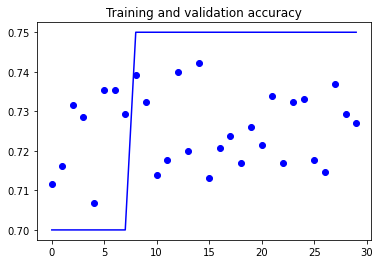

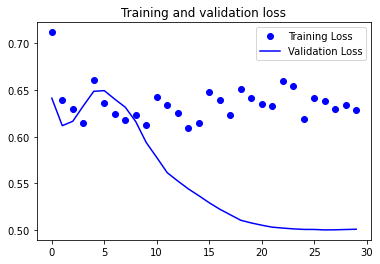

In [44]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
result = model.evaluate(x_test, y_test, batch_size=2)

10/10 [==============================] - 0s 16ms/step - loss: 0.5008 - tp: 1.0000 - tn: 14.0000 - fp: 0.0000e+00 - fn: 5.0000 - precision: 1.0000 - recall: 0.1667 - acc: 0.7500 - auc: 0.9107               


In [53]:
((result[1]+result[2]) / len(x_test)) * 100

75.0

In [54]:
y_predicted = model.predict(x_test)

predicted:  0
truth:  0.0


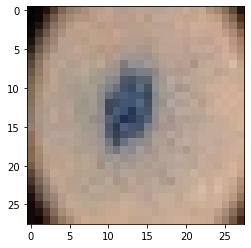

In [55]:
num = 9
y_predicted[num]
print('predicted: ', np.argmax(y_predicted[num]))

print('truth: ', y_test[num])

plt.imshow(x_test[num], cmap=plt.cm.binary)
plt.show()
# print(x_train[0])

In [62]:
from tensorflow.math import confusion_matrix


y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = confusion_matrix(labels=y_test,predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14,  0],
       [ 6,  0]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

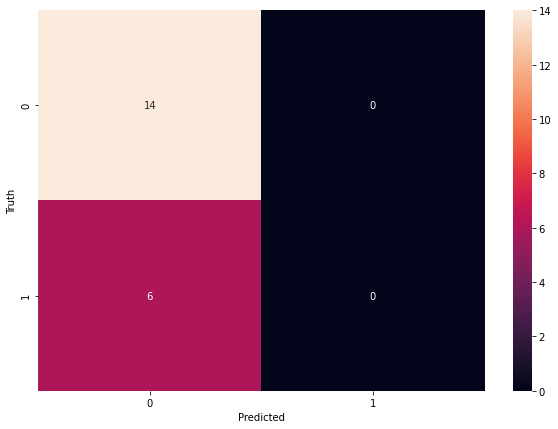

In [63]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')